## Project Processing of the data: Measurements    
In this ipynb-file the Data used for the Short Term Wind Climate is processed in such a way, that it is usable for it. 
This is done with the following steps: 

5. Import libraries, data paths, and open datasets
6. Select variables of interest
7. Create a dataframe out of them
8. Check for data gaps, NaN values, and duplicated data
9. Filter incorrect data points
10. Select data for only one year, so that buoy 2 and buoy 6 have the same length
11. Interpolate both buoy datasets, with the 140 m and 200 m to hub height of 150 m
12. Create a new dataframe for the interpolated data
13. Export it to a CSV file for further use
14. Compare Buoy 2 and 6 to ensure that the data processing didn’t go wrong
15. Plot time series of the wind speed for both met masts


The correlation should be really good, since buoy 2 consists of data corrected with data from buoy 6. So this is also a test if the steps before are done well. If the correlation is not high (r^2 ~ 0.9), then this is a sign that something went wrong in the steps before. 

REMARK: From the 01_Data_and_Windfield_Overview.ipynb we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

#### 5. Import libraries, data paths, and open datasets

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from scipy.stats import linregress
from matplotlib.projections.polar import PolarAxes
from windrose import WindroseAxes
from scipy.stats import weibull_min
from scipy import interpolate
import scipy.integrate as integrate

# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'

In [41]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

#### 6. Select variables of interest
- heights for buoy 6: 14 42 94 140 200 250
- indices for the heights: 0 1 2 3 4 5 

In future we gonna work only with the height measurements of 140 and 200 meters to interpolate 
these two heights to the hub height of 150 meter.
This is why we only convert windspeeds[:, 0, 0, 3] and winddirection_buoy_2[:, 0, 0, 3] for example.
Because these indicies stand for the two heights of interest.

In [42]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

#### 7. Create a dataframe out of the variables of interest

In [43]:
def create_buoy_dataframes(time, windspeed_140, winddirection_140, windspeed_200, winddirection_200):
    # Convert time variables to pandas datetime (though it's already in datetime64[ns] format)
    time = pd.to_datetime(time, unit='ns', origin='unix')
    
    # Create a single DataFrame for the buoy with measurements at 140m and 200m heights
    df_buoy = pd.DataFrame({
        'time': time,
        'wind_speed_140m': windspeed_140,
        'wind_direction_140m': winddirection_140,
        'wind_speed_200m': windspeed_200,
        'wind_direction_200m': winddirection_200
    }).set_index('time')
    
    return df_buoy

df_buoy_2 = create_buoy_dataframes(
    time2,
    windspeed2[:, 0, 0, 3],
    winddirection_buoy_2[:, 0, 0, 3],
    windspeed2[:, 0, 0, 4],
    winddirection_buoy_2[:, 0, 0, 4]
)

df_buoy_6 = create_buoy_dataframes(
    time6,
    windspeed6[:, 0, 0, 3],
    winddirection_buoy_6[:, 0, 0, 3],
    windspeed6[:, 0, 0, 4],
    winddirection_buoy_6[:, 0, 0, 4]
)

#close the files! 
buoy6_file.close()
buoy2_file.close() 


#### 8. Check for data gaps, NaN values, and duplicated data

In [44]:
def check_data_gaps(dataframe):
    
    dataframe.index = dataframe.index.floor('s')  # Truncate microseconds

    # Round timestamps to the nearest 10 minutes
    dataframe.index = dataframe.index.round('10min')
    
    # Generate a complete time range based on the data frequency
    full_time_range = pd.date_range(start=dataframe.index.min(), end=dataframe.index.max(), freq='10min')
    dataframe = dataframe.reindex(full_time_range)
    
    missing_data = dataframe[dataframe.isnull().any(axis=1)]
    
    total_expected = len(full_time_range)
    total_actual = len(dataframe.dropna())
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not missing_data.empty:
        print("Missing time periods are:")
        print(missing_data.index)
    else:
        print("No data gaps are found.")
    
    return missing_data

#This looks for duplicates and NaN values at the same time!
def drop_duplicates(dataframe):
    # Identify duplicate rows
    duplicates = dataframe[dataframe.duplicated(keep=False)]
    
    # Drop duplicates
    no_duplicate_data = dataframe.drop_duplicates()
    
    # Calculate data availability
    total_expected = len(dataframe)
    total_actual = len(no_duplicate_data)
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not duplicates.empty:
        # Set display options to show the entire DataFrame
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(duplicates)
    else:
        print("No duplicates are found.")
    
    return duplicates

def explore_and_prefilter_df(dataframe):
   check_data_gaps(dataframe)
   drop_duplicates(dataframe)

explore_and_prefilter_df(df_buoy_2)

Data Availability is 81.25%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-07 12:00:00', '2022-03-07 16:00:00',
               '2022-03-07 16:10:00', '2022-03-07 16:20:00',
               '2022-03-07 16:50:00', '2022-03-07 18:10:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               ...
               '2023-06-15 22:20:00', '2023-06-15 22:30:00',
               '2023-06-15 22:40:00', '2023-06-15 22:50:00',
               '2023-06-15 23:00:00', '2023-06-15 23:10:00',
               '2023-06-15 23:20:00', '2023-06-15 23:30:00',
               '2023-06-15 23:40:00', '2023-06-15 23:50:00'],
              dtype='datetime64[ns]', length=12691, freq=None)
Data Availability is 82.22%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN            

#### 9. Filter incorrect data points
#### 10. Select data for only one year, so that buoy 2 and buoy 6 have the same length

In [45]:
def replace_nan_and_select_1yr(dataframe):
    dataframe = dataframe.fillna(dataframe.mean())
    dataframe = dataframe.iloc[:52560]
    return dataframe

filtered_buoy2 = replace_nan_and_select_1yr(df_buoy_2)
#filtered_buoy2

In [46]:
explore_and_prefilter_df(df_buoy_6)
filtered_buoy6 = replace_nan_and_select_1yr(df_buoy_6)
#filtered_buoy6

Data Availability is 96.39%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               '2022-03-14 09:20:00', '2022-03-14 09:30:00',
               '2022-03-14 09:40:00', '2022-03-14 09:50:00',
               '2022-03-14 10:00:00', '2022-03-14 10:10:00',
               ...
               '2023-04-01 03:20:00', '2023-04-01 03:30:00',
               '2023-04-01 03:40:00', '2023-04-01 03:50:00',
               '2023-04-01 04:00:00', '2023-04-01 04:10:00',
               '2023-04-01 04:20:00', '2023-04-01 04:30:00',
               '2023-04-01 04:40:00', '2023-04-04 01:20:00'],
              dtype='datetime64[ns]', length=2066, freq=None)
Data Availability is 97.32%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN             

#### 11. Interpolate

We use the filtered data to do a linear interpolation to the selected hub height of 150 m. We choose linear interpolation bcs. the wind climate normally behaves exponential with the height. At our interpolation height (140 m - 200 m) we are pretty high, so we assume a linear relationship btw these points, with a high  gradient. 

#### 12. Create a new dataframe for the interpolated data

In [47]:
def interpolate_arrays(array1, array2, height1, height2, target_height):

    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1) #factor = (x-x1)/(x2-x1)
    # Perform the interpolation
    interpolated_array = array1 + factor * (array2 - array1) #formular: y1 + factor *(y2 - y1)

    return interpolated_array

ws6_150m = interpolate_arrays(filtered_buoy6['wind_speed_140m'], filtered_buoy6['wind_speed_200m'], 140, 200, 150)
wd6_150m = interpolate_arrays(filtered_buoy6['wind_direction_140m'], filtered_buoy6['wind_direction_200m'], 140, 200, 150)
ws2_150m = interpolate_arrays(filtered_buoy2['wind_speed_140m'], filtered_buoy2['wind_speed_200m'], 140, 200, 150)
wd2_150m = interpolate_arrays(filtered_buoy2['wind_direction_140m'], filtered_buoy2['wind_direction_200m'], 140, 200, 150)

# Create a new dataframe with the interpolated arrays
df_interpol_height = pd.DataFrame({
    'ws6_150m': ws6_150m,
    'wd6_150m': wd6_150m,
    'ws2_150m': ws2_150m,
    'wd2_150m': wd2_150m
})

### 13. Export, print the new dataframe and save it for the: 03_Short_Term_Wind_Climate

In [48]:
df_interpol_height.to_csv('interpolated_ws_and_wd_for_150_m.csv', index=True)
df_interpol_height


,ws6_150m,wd6_150m,ws2_150m,wd2_150m
time,,,,
2022-03-03 00:00:00,8.365000,104.643333,9.945333,105.278167
2022-03-03 00:10:00,7.921667,104.720000,7.530000,104.605000
2022-03-03 00:20:00,7.756667,107.458333,10.432167,106.897333
2022-03-03 00:30:00,7.143333,113.448333,6.643333,111.694000
2022-03-03 00:40:00,7.320000,115.078333,7.932667,111.717167
...,...,...,...,...
2023-03-02 23:10:00,7.741667,5.311667,7.541333,2.236167
2023-03-02 23:20:00,7.631667,10.411667,8.236500,10.675500
2023-03-02 23:30:00,7.453333,5.981667,6.999000,4.210167


#### 14. Compare Buoy 2 and 6 to ensure that the data processing didn’t go wrong
- R2=1: This indicates a perfect fit, meaning that the regression line explains 100% of the variance in the dependent variable.
- 0.9≤R^2<1: Indicates an excellent fit, suggesting that the model explains a very high proportion of the variance.
- 0.7≤R^2<0.9: Indicates a good fit, suggesting that the model explains a substantial proportion of the variance.
- 0.5≤R^2<0.7: Indicates a moderate fit, meaning the model explains a reasonable amount of the variance, but there is still significant unexplained variance.
- R^2<0.5: Indicates a poor fit, suggesting that the model does not explain much of the variance in the dependent variable.

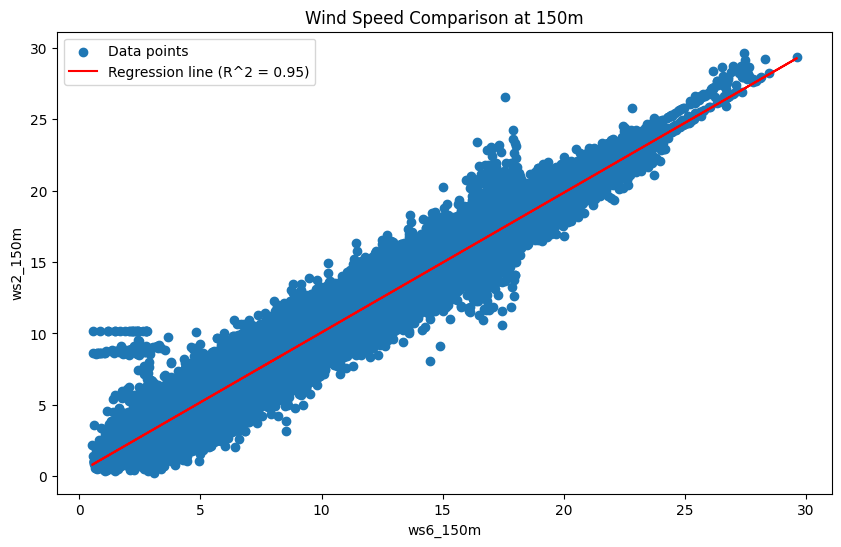

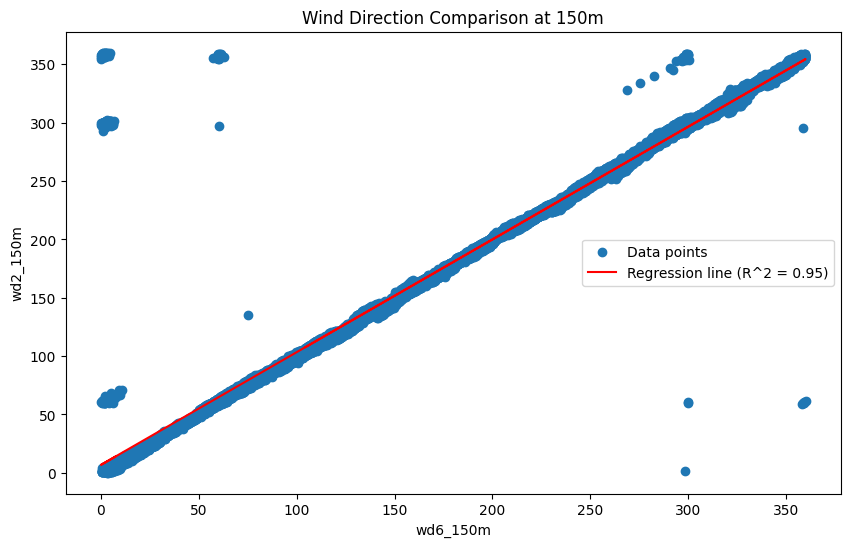

In [49]:
def plot_scatter_with_regression(x, y, xlabel, ylabel, title):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data points') #s=1 change scatter point size 

    # Plot regression line
    plt.plot(x, slope * x + intercept, color='red', label=f'Regression line (R^2 = {r_value**2:.2f})')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Scatter plot for wind speed for 52560 intervall points = one year 
plot_scatter_with_regression(df_interpol_height['ws6_150m'], df_interpol_height['ws2_150m'], 'ws6_150m', 'ws2_150m', 'Wind Speed Comparison at 150m') 
# Scatter plot for wind direction
plot_scatter_with_regression(df_interpol_height['wd6_150m'], df_interpol_height['wd2_150m'], 'wd6_150m', 'wd2_150m', 'Wind Direction Comparison at 150m')


#### 15. Plot time series of the wind speed for both met masts

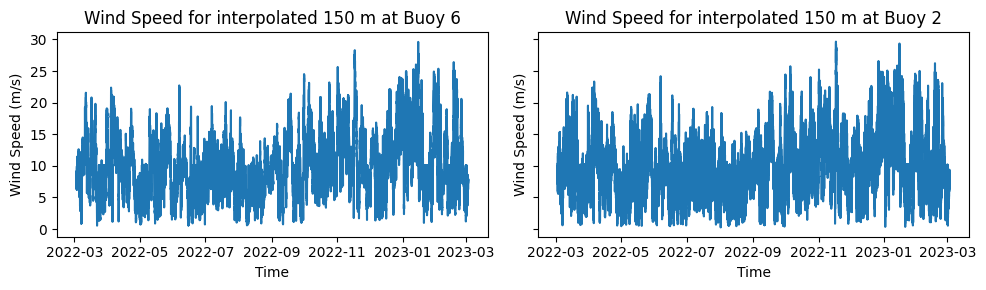

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

axes[0].plot(filtered_buoy6.index, ws6_150m)
axes[0].set_title('Wind Speed for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed (m/s)')

axes[1].plot(filtered_buoy2.index, ws2_150m)
axes[1].set_title('Wind Speed for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed (m/s)')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

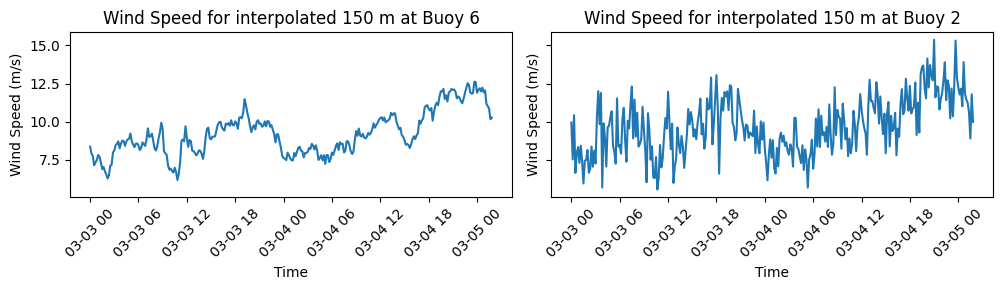

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

axes[0].plot(filtered_buoy6.index[:300], ws6_150m[:300])
axes[0].set_title('Wind Speed for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed (m/s)')
axes[0].tick_params(axis='x', rotation=45)  

axes[1].plot(filtered_buoy2.index[:300], ws2_150m[:300])
axes[1].set_title('Wind Speed for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed (m/s)')
axes[1].tick_params(axis='x', rotation=45)  


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()